In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab
%matplotlib inline 
pd.set_option('display.max_columns', None)

/usr/lib64/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
y = pd.read_csv('test.csv', header = None, index_col = 0)

In [146]:
y[1].value_counts()

1    15150
0     4048
Name: 1, dtype: int64

In [147]:
len(y)

19198

In [3]:
data = pd.read_csv('full.csv', index_col = 'POLICY_ID')
data = data.loc[data["DATA_TYPE"] == 'TRAIN', :]

In [149]:
data_corr = data.corr()

In [150]:
data_corr['POLICY_IS_RENEWED'].sort_values(ascending = False)

POLICY_IS_RENEWED                1.000000
CLIENT_HAS_OSAGO                 0.096507
CLIENT_HAS_DAGO                  0.085824
POLICY_MIN_AGE                   0.027025
POLICY_DEDUCT_VALUE             -0.000358
VEHICLE_ENGINE_POWER            -0.008983
POLICY_SALES_CHANNEL_GROUP      -0.017969
POLICY_HAS_COMPLAINTS           -0.021662
POLICY_MIN_DRIVING_EXPERIENCE   -0.024898
POLICY_SALES_CHANNEL            -0.030981
POLICY_COURT_SIGN               -0.034504
VEHICLE_SUM_INSURED             -0.037684
POLICY_BEGIN_MONTH              -0.044136
POLICY_END_MONTH                -0.044765
CLAIM_AVG_ACC_ST_PRD            -0.046212
VEHICLE_IN_CREDIT               -0.048445
POLICY_PRICE_CHANGE             -0.070610
Name: POLICY_IS_RENEWED, dtype: float64

In [4]:
train = data.copy()

# ВАЗ и Lada - одно и тоже
def map_lada(x):
    if "ВАЗ" in x:
        return "Lada"
    else:
        return x
def clear_ru_models(x):
    if 'Kalina' in x:
        return 'Kalina'
    if 'Priora' in x:
        return 'Priora'
    if 'Patriot' in x:
        return 'Patriot'
    return x
    
train['VEHICLE_MAKE'] = train['VEHICLE_MAKE'].map(map_lada)
train['VEHICLE_MODEL'] = train['VEHICLE_MODEL'].map(clear_ru_models)
# Подправим ошибки в данных
train['ERR_AGE'] = 0
for i in train.index:
    if 'Прицеп' in train.loc[i, 'VEHICLE_MODEL'] and train.loc[i, 'VEHICLE_ENGINE_POWER'] != 0:
        train.at[i, 'VEHICLE_ENGINE_POWER'] = 0
    if train.loc[i, 'VEHICLE_ENGINE_POWER'] == 0 and 'Прицеп' not in train.loc[i, 'VEHICLE_MODEL']:
        train.at[i, 'VEHICLE_ENGINE_POWER'] = np.nan
    # Можно оптимальнее, уже не хочу переписывать рабочий код
    if train.loc[i, 'VEHICLE_ENGINE_POWER'] > 1000:
        train.at[i, 'VEHICLE_ENGINE_POWER'] = train.loc[i, 'VEHICLE_ENGINE_POWER'] / 10
    if train.loc[i, 'POLICY_MIN_DRIVING_EXPERIENCE'] > 1900:
        train.at[i, 'POLICY_MIN_DRIVING_EXPERIENCE'] = 2018 - train.loc[i, 'POLICY_MIN_DRIVING_EXPERIENCE']
    # Кто-то имеет ВУ, полученное раньше 16 лет?
    if train.loc[i, 'POLICY_MIN_AGE'] - train.loc[i, 'POLICY_MIN_DRIVING_EXPERIENCE'] > 16:
        train.at[i, 'ERR_AGE'] = 1        
        
train['VEHICLE_ENGINE_POWER'] = train.groupby('VEHICLE_MAKE')['VEHICLE_ENGINE_POWER'].apply(lambda x: x.fillna(x.mean()))
train['VEHICLE_ENGINE_POWER'] = train['VEHICLE_ENGINE_POWER'].fillna(value = train['VEHICLE_ENGINE_POWER'].mean())
train['VEHICLE_ENGINE_POWER'] = train['VEHICLE_ENGINE_POWER'].map(np.floor)

train.at[train['POLICY_INTERMEDIARY'] == 'N', 'POLICY_INTERMEDIARY'] = 0
train['POLICY_INTERMEDIARY'] = train['POLICY_INTERMEDIARY'].astype('int64')
train['INSURER_GENDER'] = train['INSURER_GENDER'].map({'M': 0, 'F': 1})
train['POLICY_BRANCH'] = train['POLICY_BRANCH'].map({'Москва': 0, 'Санкт-Петербург': 1})
train['POLICY_DEDUCT_VALUE'] = train['POLICY_DEDUCT_VALUE'].map(np.floor)
# VEHICLE_SUM_INSURED == 0 - явная ошибка, но таких 42 записи. Модель должна обучиться, но мне нужно ненулевое значение.
train.at[train['VEHICLE_SUM_INSURED'] == 0, 'VEHICLE_SUM_INSURED'] = np.nan
train['VEHICLE_SUM_INSURED'] = train.groupby('VEHICLE_MODEL')['VEHICLE_SUM_INSURED'].apply(lambda x: x.fillna(x.median()))
train['VEHICLE_SUM_INSURED'] = train.groupby('VEHICLE_MAKE')['VEHICLE_SUM_INSURED'].apply(lambda x: x.fillna(x.median()))
train['VEHICLE_SUM_INSURED'] = train['VEHICLE_SUM_INSURED'].fillna(value = train['VEHICLE_SUM_INSURED'].mean()) # Хотя может логичнее и выбросить, так как единственный и в train

train['DEDUCT_RATIO'] = train['POLICY_DEDUCT_VALUE'].divide(train['VEHICLE_SUM_INSURED'])
train['STARTED_TO_DRIVE'] = train['POLICY_MIN_AGE'] - train['POLICY_MIN_DRIVING_EXPERIENCE']

train.at[train['POLICY_YEARS_RENEWED_N'] == 'N', 'POLICY_YEARS_RENEWED_N'] = '0'
train['POLICY_YEARS_RENEWED_N'] = train['POLICY_YEARS_RENEWED_N'].astype('int64')
train['INSURANCE_RATIO'] = train['POLICY_YEARS_RENEWED_N'].divide(train['POLICY_MIN_AGE'])
train['INSURANCE_RATIO'] = train['INSURANCE_RATIO'].map(lambda x: -1 if (x == np.nan) or (x == np.inf) else x)

train['VEHICLE_MODEL'] = train['VEHICLE_MAKE'] + ' ' + train['VEHICLE_MODEL']

# Страховка на год
train['YEAR_INSURANCE'] = 1
train.at[abs(train['POLICY_BEGIN_MONTH'] - train['POLICY_END_MONTH']) % 11 > 1, 'YEAR_INSURANCE'] = 0
train['POLICY_PRICE_CHANGE_SIGN'] = train['POLICY_PRICE_CHANGE'].map(np.sign)

train['FIRST_YEAR_DRIVING'] = train['POLICY_MIN_DRIVING_EXPERIENCE'].map(lambda x: 1 if x == 0 else 0)
train['AGE_STARTED'] = train['POLICY_MIN_AGE'] - train['POLICY_MIN_DRIVING_EXPERIENCE']
train['AGE_STARTED'] = train['AGE_STARTED'].map(lambda x: 16 if x < 16 else x)
for column in ['POLICY_CLM_N', 'POLICY_CLM_GLT_N', 'POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N']:
    train[column + '_INIT'] = train[column]
    train[column + '_INIT'] = train[column + '_INIT'].map(lambda x: 'N' if x == 'n/d' else x)
for column in ['POLICY_CLM_N', 'POLICY_CLM_GLT_N', 'POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N']:
    train[column] = train[column].map(lambda x: 'N' if x == 'n/d' else x)
    train[column + '_C'] = train[column].map(lambda x: 0 if (x == '0') or (x == 'N') or (x == '1L') else 1)
    train[column] = train[column].map(lambda x: '0' if x == 'N' else '1' if (x == '1S') or (x == '1L') else '4' if x == '4+' else x)
    train[column] = train[column].astype('int')
train['NO_CLM'] = (train['POLICY_CLM_N'] == 0).mul(train['POLICY_PRV_CLM_N'] == 0).map(lambda x: 1 if x else 0)
train['NO_CLM_GLT'] = (train['POLICY_CLM_GLT_N'] == 0).mul(train['POLICY_PRV_CLM_GLT_N'] == 0).map(lambda x: 1 if x else 0)

train['BAD_TEND'] = (train['POLICY_CLM_N'] > train['POLICY_PRV_CLM_N']) | ((train['POLICY_CLM_N_C'] - train['POLICY_PRV_CLM_N_C']) > 0)
train['BAD_TEND'] = train['BAD_TEND'].map(lambda x: 1 if x else 0)

train['YOUNG'] = train['POLICY_MIN_AGE'].map(lambda x: 1 if x <= 25 else 0)
train['LOW_EXP'] = train['POLICY_MIN_DRIVING_EXPERIENCE'].map(lambda x: 1 if x <= 3 else 0)

#for column in ['POLICY_MIN_AGE', 'POLICY_MIN_DRIVING_EXPERIENCE', 'VEHICLE_SUM_INSURED', 'VEHICLE_ENGINE_POWER']:
#    train[column] = train[column].map(np.log1p)

columns = ['CLAIM_AVG_ACC_ST_PRD', 'POLICY_DEDUCT_VALUE', 'POLICY_PRICE_CHANGE', 'POLICY_YEARS_RENEWED_N']
for column in columns:
    mean = train[column].mean()
    train[column + '_RATIO'] = train[column] / mean
train['NO_DEDUCT'] = train['POLICY_DEDUCT_VALUE'].map(lambda x: 1 if x == 0 else 0)

ohe = LabelEncoder()
columns = ['VEHICLE_MAKE', 'VEHICLE_MODEL', 'CLIENT_REGISTRATION_REGION', 'POLICY_SALES_CHANNEL', 'POLICY_SALES_CHANNEL_GROUP', 'POLICY_BRANCH', 'POLICY_INTERMEDIARY', 'POLICY_CLM_N_INIT', 'POLICY_CLM_GLT_N_INIT', 'POLICY_PRV_CLM_N_INIT', 'POLICY_PRV_CLM_GLT_N_INIT']
for column in columns:
    train[column] = ohe.fit_transform(train[column])

train['ENGINE_POWER_BINS'] = pd.cut(train['VEHICLE_ENGINE_POWER'], bins = [-1, 50, 70, 100, 150, 200, 250, 300, 350, 400, 500, 600, 1000], labels = False)
train['MIN_AGE_BINS'] = pd.cut(train['POLICY_MIN_AGE'], bins = 6, labels = False)
train['EXPERIENCE_BINS'] = pd.cut(train['POLICY_MIN_DRIVING_EXPERIENCE'], bins = [-1, 0, 3, 10, 20, 30, 40, 50, 100], labels = False)
train['SUM_BINS'] = pd.cut(train['VEHICLE_SUM_INSURED'], bins = [0, 50000, 100000, 200000, 300000, 500000, 1000000, 2000000, 3000000, 10000000], labels = False)
train['PRD_BINS_Q'] = pd.qcut(train['VEHICLE_SUM_INSURED'], q = 10, labels = False)
train['PRD_BINS'] = pd.cut(train['VEHICLE_SUM_INSURED'], bins = 10, labels = False)
train['CLAIM_BINS_Q'] = pd.cut(train['CLAIM_AVG_ACC_ST_PRD'], bins = 5, labels = False)
train['DEDUCT_BINS'] = pd.cut(train['POLICY_DEDUCT_VALUE'], bins = 5, labels = False)
train['PRICE_BINS'] = pd.cut(train['POLICY_PRICE_CHANGE'], bins = 10, labels = False)
train = train.drop('POLICY_END_MONTH', axis = 1)
train['COMPL_AND_COURT'] = train['POLICY_HAS_COMPLAINTS'] + train['POLICY_COURT_SIGN']
train['COMPL_OR_COURT'] = train['COMPL_AND_COURT'].map(lambda x: 0 if x == 0 else 1)

N = 10
kmeans = KMeans(n_clusters = N, init = 'k-means++', random_state = 42)
train['f1'] = kmeans.fit_predict(train[['INSURER_GENDER', 'MIN_AGE_BINS', 'SUM_BINS', 'DEDUCT_BINS']])
train['f2'] = kmeans.fit_predict(train[['INSURER_GENDER', 'MIN_AGE_BINS', 'CLIENT_REGISTRATION_REGION']])
train['f3'] = kmeans.fit_predict(train[['INSURER_GENDER', 'MIN_AGE_BINS']])
train['f4'] = kmeans.fit_predict(train[['INSURER_GENDER', 'MIN_AGE_BINS', 'ENGINE_POWER_BINS']])
train['f5'] = kmeans.fit_predict(train[['INSURER_GENDER', 'MIN_AGE_BINS', 'SUM_BINS', 'DEDUCT_BINS']])
train['f6'] = kmeans.fit_predict(train[['INSURER_GENDER', 'MIN_AGE_BINS', 'POLICY_HAS_COMPLAINTS', 'POLICY_COURT_SIGN']])
train['f7'] = kmeans.fit_predict(train[['INSURER_GENDER', 'MIN_AGE_BINS', 'COMPL_OR_COURT']])
train['f8'] = kmeans.fit_predict(train[['INSURER_GENDER', 'MIN_AGE_BINS', 'COMPL_AND_COURT']])


columns = ['POLICY_YEARS_RENEWED_N', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 'CLIENT_REGISTRATION_REGION', 'POLICY_SALES_CHANNEL', 'POLICY_SALES_CHANNEL_GROUP', 'POLICY_BRANCH', 'POLICY_INTERMEDIARY', 'ENGINE_POWER_BINS', 'MIN_AGE_BINS', 'EXPERIENCE_BINS', 'SUM_BINS', 'PRD_BINS_Q', 'PRD_BINS', 'CLAIM_BINS_Q', 'DEDUCT_BINS', 'PRICE_BINS', 'POLICY_CLM_N_INIT', 'POLICY_CLM_GLT_N_INIT', 'POLICY_PRV_CLM_N_INIT', 'POLICY_PRV_CLM_GLT_N_INIT', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']#, 'POLICY_CLM_N', 'POLICY_CLM_GLT_N', 'POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N']
for column in columns:
    train = pd.get_dummies(train, columns = [column], prefix = column)

In [152]:
corrmat = train.corr()

In [153]:
corr_vect = abs(corrmat['POLICY_IS_RENEWED']).sort_values(ascending = False)
for i in corr_vect.index:
    print(i, corr_vect[i])

POLICY_IS_RENEWED 1.0
POLICY_CLM_GLT_N 0.18713681197413587
POLICY_CLM_N 0.16420586381351515
POLICY_CLM_GLT_N_INIT_0 0.14866083000059044
POLICY_PRV_CLM_N_INIT_6 0.14018834330362925
POLICY_PRV_CLM_GLT_N_INIT_6 0.14018834330362925
POLICY_YEARS_RENEWED_N_0 0.14018834330362925
POLICY_CLM_GLT_N_C 0.13030954182293686
BAD_TEND 0.1254157408530792
POLICY_CLM_N_INIT_0 0.12336286972134777
POLICY_CLM_N_C 0.12049268432677168
POLICY_PRV_CLM_GLT_N_INIT_0 0.11880828072783739
POLICY_CLM_GLT_N_INIT_3 0.11665143063345483
POLICY_YEARS_RENEWED_N_RATIO 0.11146881745822527
POLICY_PRICE_CHANGE_SIGN 0.11066179970793937
POLICY_PRV_CLM_N_INIT_0 0.10837072815150765
NO_CLM_GLT 0.0991738098690095
CLIENT_REGISTRATION_REGION_56 0.09849633594324529
INSURANCE_RATIO 0.09804129447862
POLICY_CLM_GLT_N_INIT_4 0.09677665593738911
CLIENT_HAS_OSAGO 0.09650659951847196
POLICY_CLM_N_INIT_3 0.09581133474241106
POLICY_CLM_N_INIT_4 0.08994682267992471
CLIENT_HAS_DAGO 0.0858237569580539
POLICY_BRANCH_0 0.08518520512956798
POLICY_BRA

VEHICLE_MODEL_246 0.007239361067528406
VEHICLE_MODEL_500 0.007225135261983675
POLICY_INTERMEDIARY_65 0.007153571735736464
POLICY_INTERMEDIARY_956 0.007119265384326035
CLIENT_REGISTRATION_REGION_57 0.007115578535031558
POLICY_INTERMEDIARY_1207 0.007110188584243218
POLICY_SALES_CHANNEL_59 0.007105475765930059
VEHICLE_MODEL_483 0.007065017150494301
POLICY_INTERMEDIARY_339 0.007054846112162746
SUM_BINS_1 0.007054846112161501
POLICY_INTERMEDIARY_881 0.0070548461121603704
POLICY_INTERMEDIARY_202 0.007054846112160266
POLICY_INTERMEDIARY_635 0.007054846112158055
POLICY_INTERMEDIARY_15 0.007054846112156953
POLICY_INTERMEDIARY_1036 0.007054846112156117
VEHICLE_MAKE_75 0.007054846112154067
VEHICLE_MODEL_575 0.007054846112154067
POLICY_INTERMEDIARY_1168 0.007054846112153285
POLICY_INTERMEDIARY_114 0.007044167737805839
POLICY_INTERMEDIARY_1198 0.006996733457224735
POLICY_INTERMEDIARY_1145 0.006996733457218072
POLICY_SALES_CHANNEL_16 0.006996139958880023
VEHICLE_MODEL_232 0.006941426042008055
VEHICL

VEHICLE_MODEL_6 0.004822752172233258
POLICY_INTERMEDIARY_338 0.004822752172232927
POLICY_INTERMEDIARY_748 0.00482275217223289
POLICY_INTERMEDIARY_1271 0.004822752172232688
VEHICLE_MODEL_112 0.0048227521722325195
POLICY_INTERMEDIARY_1108 0.004822752172232346
VEHICLE_MODEL_146 0.004822752172231554
POLICY_INTERMEDIARY_310 0.004822752172231243
VEHICLE_MODEL_109 0.004822752172231205
POLICY_INTERMEDIARY_322 0.004822752172230997
POLICY_INTERMEDIARY_756 0.0048227521722307405
POLICY_INTERMEDIARY_264 0.004822752172230695
POLICY_INTERMEDIARY_786 0.0048227521722301065
POLICY_INTERMEDIARY_752 0.004822752172230058
POLICY_INTERMEDIARY_9 0.004822752172229777
VEHICLE_MODEL_147 0.004822752172229765
POLICY_INTERMEDIARY_674 0.004822752172229436
POLICY_INTERMEDIARY_694 0.004822752172229422
VEHICLE_MODEL_251 0.004822752172229061
POLICY_INTERMEDIARY_285 0.0048227521722286
POLICY_INTERMEDIARY_146 0.004822752172228579
POLICY_INTERMEDIARY_95 0.0048227521722284
VEHICLE_MODEL_161 0.0048227521722280335
POLICY_INTE

VEHICLE_MAKE_63 0.004018272976821818
VEHICLE_MODEL_387 0.004006287403358245
POLICY_INTERMEDIARY_1128 0.003939872133576514
POLICY_INTERMEDIARY_1329 0.003939872133575636
POLICY_INTERMEDIARY_1022 0.003937735223133087
VEHICLE_MODEL_498 0.003937735223133051
POLICY_INTERMEDIARY_374 0.003937735223130933
VEHICLE_MODEL_226 0.0039377352231307365
POLICY_INTERMEDIARY_251 0.003937735223130592
VEHICLE_MODEL_486 0.003937735223130034
POLICY_INTERMEDIARY_23 0.0039377352231297165
VEHICLE_MODEL_22 0.003937735223129176
POLICY_INTERMEDIARY_478 0.003937735223129095
POLICY_INTERMEDIARY_529 0.003937735223128479
VEHICLE_MODEL_433 0.003937735223128361
POLICY_INTERMEDIARY_243 0.003937735223128125
VEHICLE_MODEL_128 0.003937735223127957
POLICY_INTERMEDIARY_689 0.003937735223127924
POLICY_INTERMEDIARY_543 0.003937735223127909
POLICY_INTERMEDIARY_212 0.003937735223127907
POLICY_INTERMEDIARY_248 0.003937735223127873
POLICY_INTERMEDIARY_883 0.003937735223127815
POLICY_INTERMEDIARY_1110 0.003937735223127508
VEHICLE_MOD

POLICY_INTERMEDIARY_43 0.0027843812930518374
POLICY_INTERMEDIARY_773 0.002784381293051832
POLICY_INTERMEDIARY_547 0.0027843812930517984
POLICY_INTERMEDIARY_1041 0.002784381293051794
POLICY_INTERMEDIARY_899 0.002784381293051778
POLICY_INTERMEDIARY_1199 0.002784381293051736
POLICY_INTERMEDIARY_844 0.0027843812930517286
POLICY_INTERMEDIARY_772 0.0027843812930517017
POLICY_INTERMEDIARY_201 0.002784381293051667
POLICY_INTERMEDIARY_1280 0.0027843812930516665
POLICY_INTERMEDIARY_785 0.0027843812930516436
POLICY_INTERMEDIARY_1241 0.0027843812930516297
POLICY_INTERMEDIARY_69 0.002784381293051622
POLICY_INTERMEDIARY_729 0.0027843812930515707
POLICY_INTERMEDIARY_999 0.0027843812930515546
VEHICLE_MODEL_324 0.002784381293051545
VEHICLE_MAKE_42 0.002784381293051545
POLICY_INTERMEDIARY_638 0.0027843812930515312
POLICY_INTERMEDIARY_952 0.0027843812930515187
POLICY_INTERMEDIARY_190 0.0027843812930514363
POLICY_INTERMEDIARY_110 0.0027843812930513512
POLICY_INTERMEDIARY_366 0.0027843812930513456
POLICY_I

POLICY_INTERMEDIARY_1170 0.0020543958121673183
VEHICLE_MAKE_9 0.002054395812165958
f4_6 0.0020442638298161075
VEHICLE_MODEL_219 0.0020435775616037865
POLICY_INTERMEDIARY_765 0.0020435775616032205
POLICY_INTERMEDIARY_143 0.002029158852913708
POLICY_INTERMEDIARY_181 0.0020001510969133393
VEHICLE_MODEL_535 0.001982443803865307
POLICY_INTERMEDIARY_617 0.001980330505287004
VEHICLE_MODEL_271 0.0019665777196194996
VEHICLE_MODEL_513 0.001964035787942792
POLICY_INTERMEDIARY_736 0.0019577110891961878
POLICY_INTERMEDIARY_1316 0.001957711089193814
POLICY_INTERMEDIARY_422 0.0019577110891926307
POLICY_INTERMEDIARY_754 0.001957711089191158
VEHICLE_MODEL_206 0.001933732168451046
POLICY_INTERMEDIARY_967 0.0019177538073888026
CLIENT_REGISTRATION_REGION_48 0.0019177538073876135
VEHICLE_MODEL_444 0.001908961635682121
POLICY_SALES_CHANNEL_26 0.0018998331895070937
VEHICLE_MODEL_201 0.0018961273466195398
VEHICLE_MODEL_545 0.001882533027827418
POLICY_INTERMEDIARY_385 0.0018693979246546754
ENGINE_POWER_BINS_6 

VEHICLE_MODEL_165 0.0010514591881264437
VEHICLE_MODEL_367 0.0010514591881263212
VEHICLE_MODEL_421 0.001051459188126219
POLICY_INTERMEDIARY_915 0.0010514591881255711
VEHICLE_MODEL_89 0.0010514591881255523
POLICY_INTERMEDIARY_944 0.0010514591881247049
POLICY_INTERMEDIARY_299 0.0010514591881233357
f3_0 0.001038499858713707
f7_1 0.001038499858713707
f8_4 0.001038499858713707
f6_4 0.001038499858713707
VEHICLE_MODEL_426 0.0010150112822173423
VEHICLE_MODEL_386 0.0009784897243321506
POLICY_INTERMEDIARY_157 0.000969217042664358
VEHICLE_MODEL_335 0.0009692170426639869
VEHICLE_MODEL_284 0.0009692170426610805
POLICY_INTERMEDIARY_1146 0.0009644466786875193
VEHICLE_MAKE_12 0.0009624762550696018
VEHICLE_MODEL_310 0.0009290383031234179
VEHICLE_MODEL_240 0.000929038303122302
CLIENT_REGISTRATION_REGION_59 0.0009290383031215138
POLICY_INTERMEDIARY_564 0.00092903830312133
POLICY_INTERMEDIARY_50 0.0009290383031206254
VEHICLE_MAKE_28 0.0009290383031196294
VEHICLE_MODEL_282 0.0009290383031189619
PRD_BINS_Q_3

In [5]:
train = train.reset_index()

In [7]:
print(train['POLICY_IS_RENEWED'].value_counts())
print(train['POLICY_IS_RENEWED'].count())

1    48376
0    29031
Name: POLICY_IS_RENEWED, dtype: int64
77407


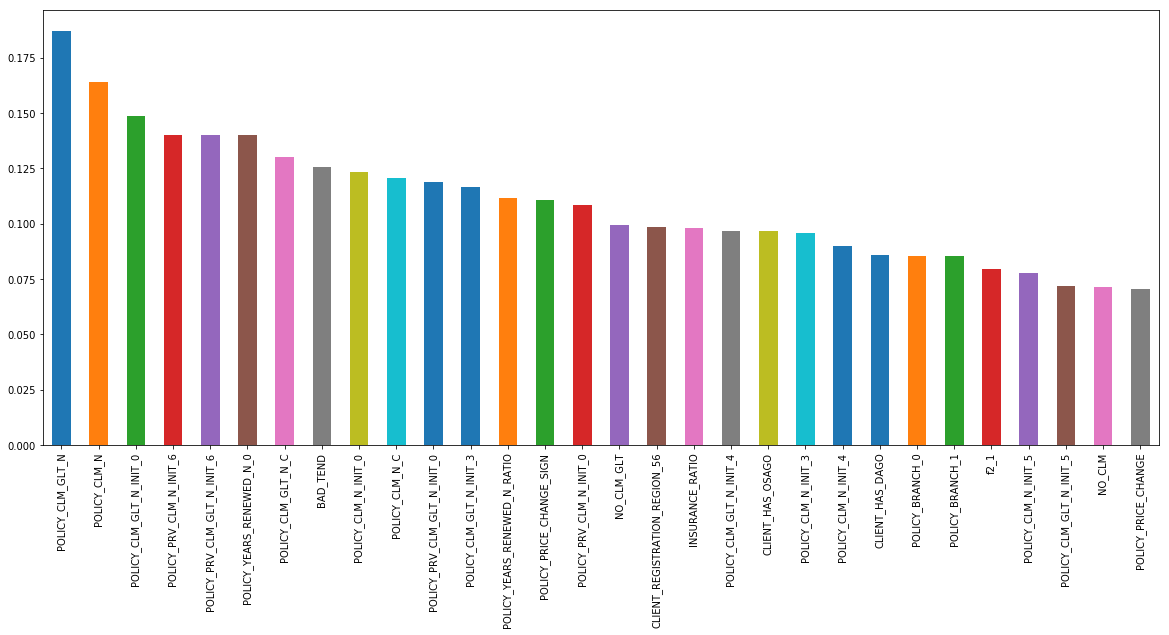

In [155]:
corr_vect.head(31)[1:].plot(kind = 'bar' , figsize = (20, 8))

In [156]:
train.groupby(['POLICY_IS_RENEWED'])['POLICY_MIN_AGE'].describe()

,count,mean,std,min,25%,50%,75%,max
POLICY_IS_RENEWED,,,,,,,,
0,29031.0,42.253557,10.897712,18.0,34.0,41.0,50.0,82.0
1,48376.0,42.851683,10.598057,18.0,35.0,42.0,50.0,86.0


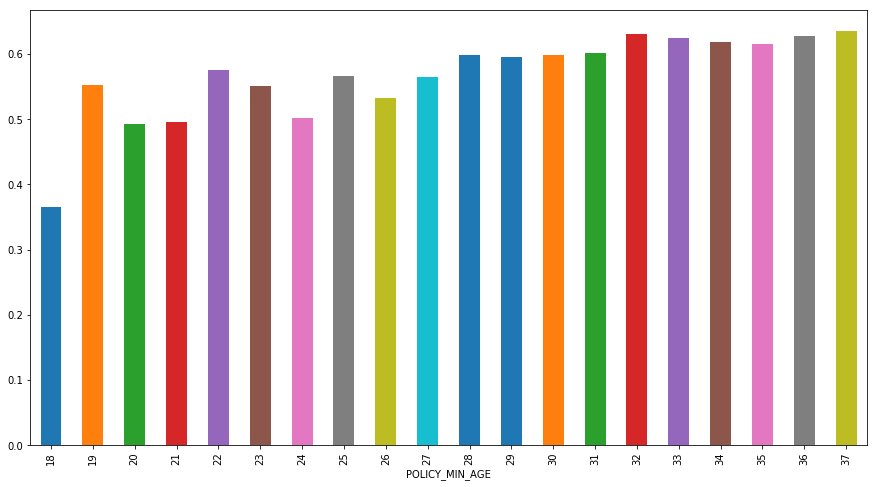

In [199]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['POLICY_MIN_AGE'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(20).plot(kind = 'bar', figsize = (15, 8))

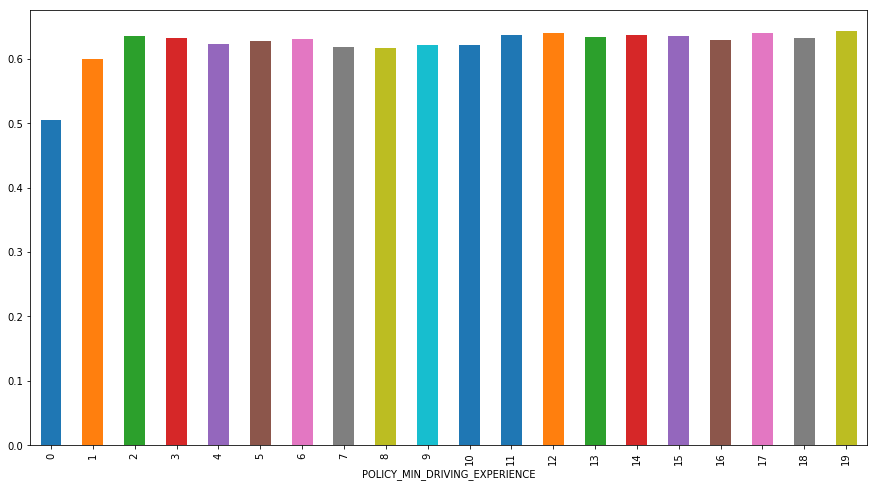

In [200]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['POLICY_MIN_DRIVING_EXPERIENCE'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(20).plot(kind = 'bar', figsize = (15, 8))

In [158]:
pd.crosstab(train['POLICY_IS_RENEWED'], train['FIRST_YEAR_DRIVING'], margins = True)

FIRST_YEAR_DRIVING,0,1,All
POLICY_IS_RENEWED,,,
0,27760,1271,29031
1,47077,1299,48376
All,74837,2570,77407


In [159]:
train.groupby(['POLICY_IS_RENEWED'])['POLICY_MIN_DRIVING_EXPERIENCE'].describe()

,count,mean,std,min,25%,50%,75%,max
POLICY_IS_RENEWED,,,,,,,,
0,29031.0,14.519445,9.460243,0.0,8.0,13.0,19.0,60.0
1,48376.0,14.767323,9.200125,0.0,8.0,14.0,19.0,58.0


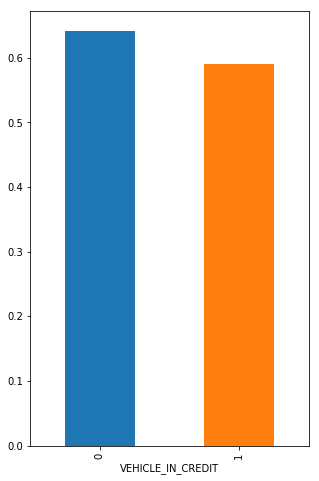

In [183]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['VEHICLE_IN_CREDIT'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))

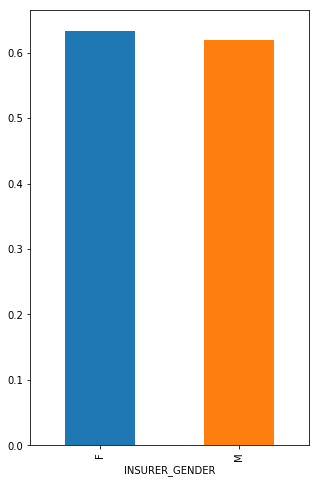

In [184]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['INSURER_GENDER'].map({0: 'M', 1: 'F'}), margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))

In [162]:
train.groupby(['POLICY_IS_RENEWED'])['POLICY_CLM_N'].describe()

,count,mean,std,min,25%,50%,75%,max
POLICY_IS_RENEWED,,,,,,,,
0,29031.0,0.570149,0.892362,0.0,0.0,0.0,1.0,4.0
1,48376.0,0.318918,0.613504,0.0,0.0,0.0,1.0,4.0


In [163]:
train.groupby(['POLICY_IS_RENEWED'])['POLICY_CLM_GLT_N'].describe()

,count,mean,std,min,25%,50%,75%,max
POLICY_IS_RENEWED,,,,,,,,
0,29031.0,0.502876,0.836876,0.0,0.0,0.0,1.0,4.0
1,48376.0,0.242786,0.528026,0.0,0.0,0.0,0.0,4.0


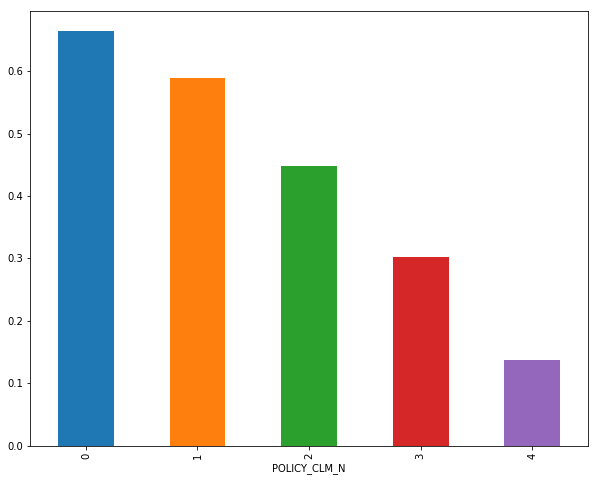

In [185]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['POLICY_CLM_N'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(5).plot(kind = 'bar', figsize = (10, 8))

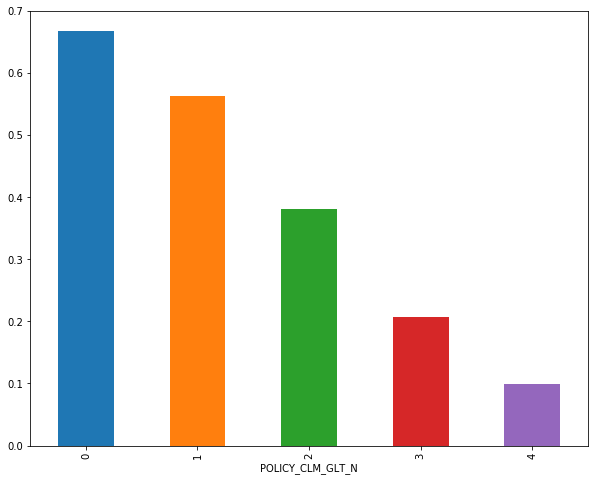

In [186]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['POLICY_CLM_GLT_N'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(5).plot(kind = 'bar', figsize = (10, 8))

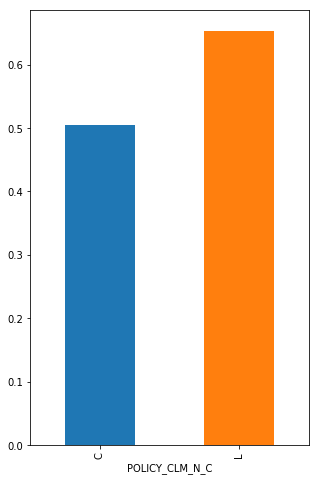

In [6]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['POLICY_CLM_N_C'].map({0: 'L', 1: 'C'}), margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))

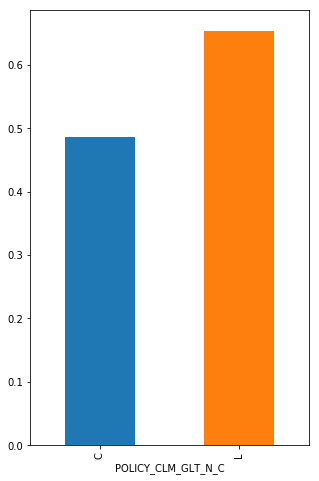

In [7]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['POLICY_CLM_GLT_N_C'].map({0: 'L', 1: 'C'}), margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))

In [166]:
train.groupby(['POLICY_IS_RENEWED'])['VEHICLE_SUM_INSURED'].describe()

,count,mean,std,min,25%,50%,75%,max
POLICY_IS_RENEWED,,,,,,,,
0,29031.0,1.013920e+06,724006.269161,44550.0,567900.0,822000.0,1217384.5,9449000.0
1,48376.0,9.604392e+05,663644.745100,23230.0,552500.0,800000.0,1130780.0,7543535.0


In [167]:
train.groupby(['POLICY_IS_RENEWED'])['POLICY_DEDUCT_VALUE'].describe()

,count,mean,std,min,25%,50%,75%,max
POLICY_IS_RENEWED,,,,,,,,
0,29031.0,5969.826151,10681.272008,0.0,0.0,0.0,10000.0,78404.0
1,48376.0,5962.136659,10223.933097,0.0,0.0,0.0,10000.0,120873.0


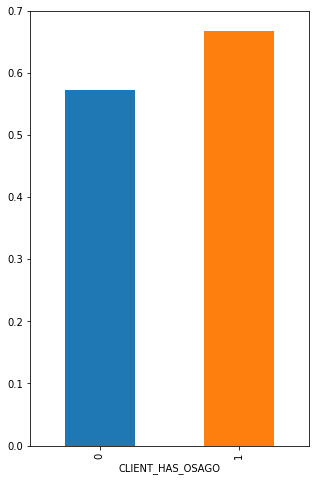

In [187]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['CLIENT_HAS_OSAGO'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))

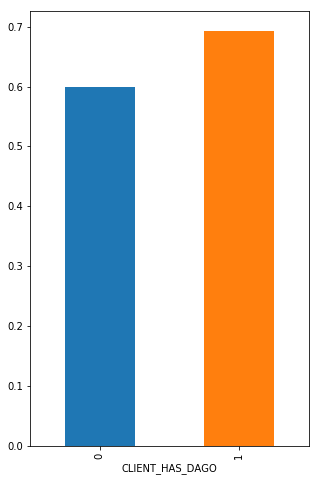

In [188]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['CLIENT_HAS_DAGO'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))

YEAR_INSURANCE,0,1,All
POLICY_IS_RENEWED,,,
0,31,29000,29031
1,1,48375,48376
All,32,77375,77407


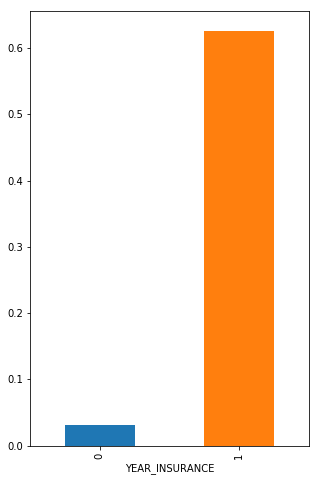

In [189]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['YEAR_INSURANCE'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))
tab1

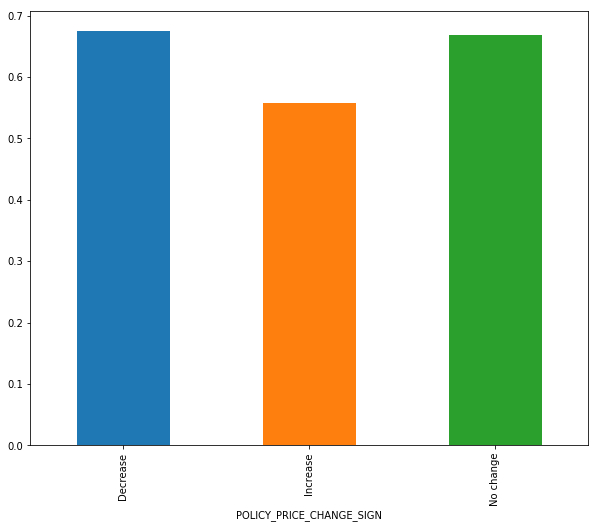

In [190]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['POLICY_PRICE_CHANGE_SIGN'].map({-1: 'Decrease', 0: 'No change', 1: 'Increase'}), margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(3).plot(kind = 'bar', figsize = (10, 8))

In [172]:
train.groupby(['POLICY_IS_RENEWED'])['POLICY_PRICE_CHANGE'].describe()

,count,mean,std,min,25%,50%,75%,max
POLICY_IS_RENEWED,,,,,,,,
0,29031.0,0.042823,1.324401,-1.0,-0.19,0.0,0.05,60.02
1,48376.0,-0.079306,0.252618,-1.0,-0.17,0.0,0.04,14.04


INSURER_GENDER,F,M
POLICY_CLM_N,,
0,0.680031,0.718619
1,0.217139,0.202114
2,0.074568,0.058214
3,0.020854,0.016005
4,0.007408,0.005049


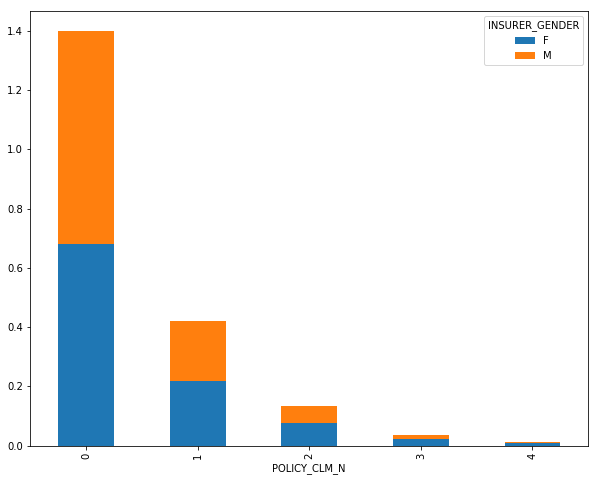

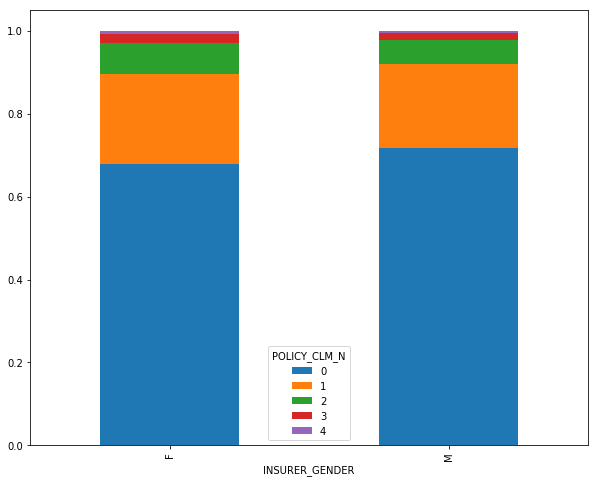

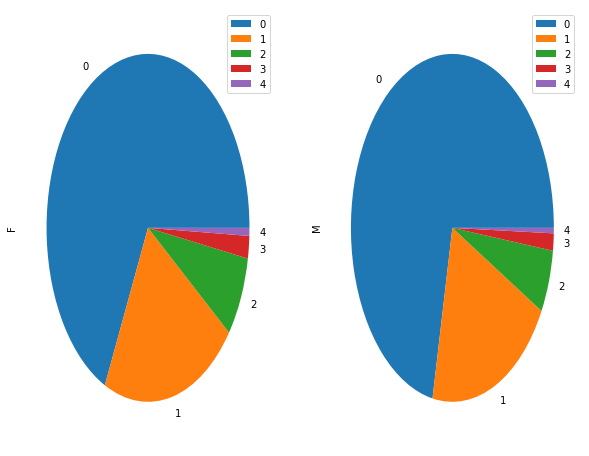

In [204]:
tab1 = pd.crosstab(train['POLICY_CLM_N'], train['INSURER_GENDER'].map({0: 'M', 1: 'F'}), margins = True).transpose()
for column in tab1.columns[:-1]:
    tab1.at[:, column] = tab1.loc[:, column].divide(tab1.loc[:, 'All'])
tab1 = tab1.drop('All', axis = 1).drop('All').transpose()
tab1.plot.bar(stacked = 'Yes', figsize = (10, 8))
tab1.transpose().plot.bar(stacked = 'Yes', figsize = (10, 8))
tab1.plot(kind = 'pie', figsize = (10, 8), subplots = True)
tab1
# tab1.loc[1, :].divide(tab1.loc[0, :]).head(5).plot(kind = 'bar', figsize = (10, 8))

In [174]:
train.groupby(['INSURER_GENDER'])['POLICY_CLM_N'].describe()

,count,mean,std,min,25%,50%,75%,max
INSURER_GENDER,,,,,,,,
0,48923.0,0.386751,0.714301,0.0,0.0,0.0,1.0,4.0
1,28484.0,0.458468,0.781951,0.0,0.0,0.0,1.0,4.0


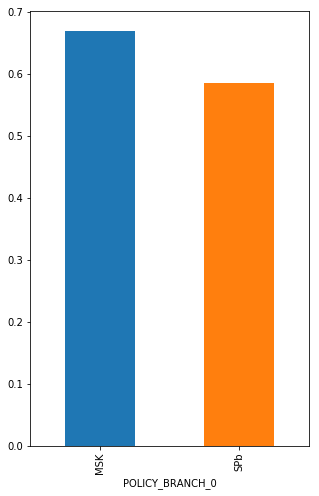

In [201]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['POLICY_BRANCH_0'].map({0: 'MSK', 1: 'SPb'}), margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))

POLICY_YEARS_RENEWED_N,0,1,2,3,4,5,6,7,8,9,10,All
POLICY_IS_RENEWED,,,,,,,,,,,,
0,12503,6594,4302,2951,1601,487,372,186,21,13,1,29031
1,14177,13667,7928,6310,3342,1319,1021,481,69,49,13,48376
All,26680,20261,12230,9261,4943,1806,1393,667,90,62,14,77407


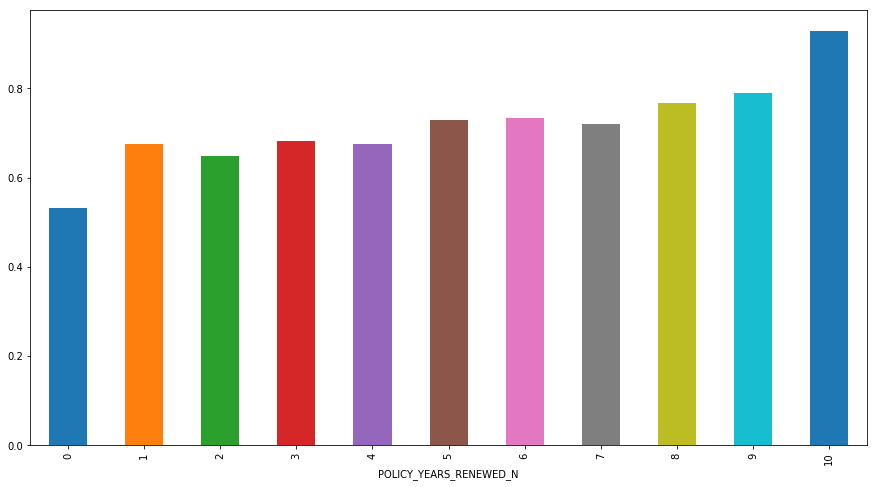

In [192]:
tab1 = pd.crosstab(data['POLICY_IS_RENEWED'], data['POLICY_YEARS_RENEWED_N'].map(lambda x: '0' if x == 'N' else x).astype('int'), margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(11).plot(kind = 'bar', figsize = (15, 8))
tab1

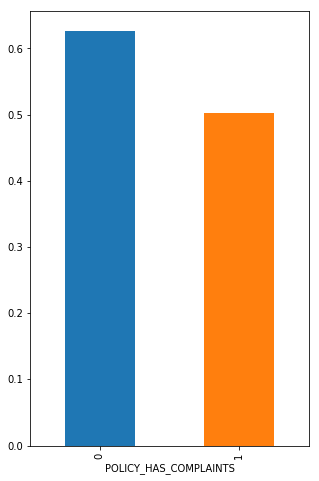

In [205]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['POLICY_HAS_COMPLAINTS'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))

POLICY_COURT_SIGN,0,1,All
POLICY_IS_RENEWED,,,
0,28962,69,29031
1,48369,7,48376
All,77331,76,77407


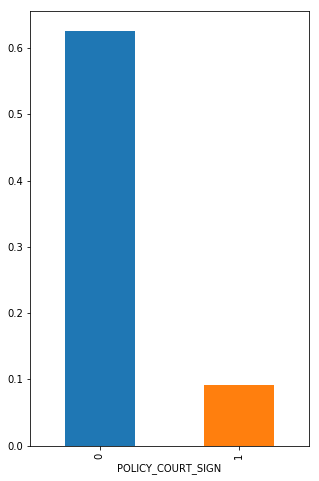

In [219]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['POLICY_COURT_SIGN'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))
tab1

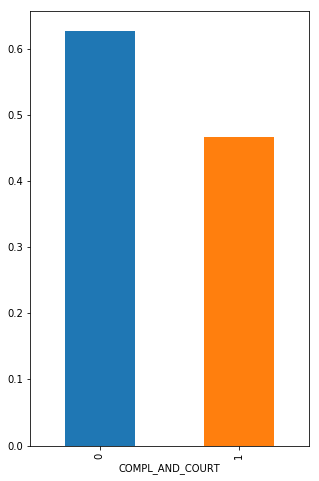

In [210]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['COMPL_AND_COURT'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))

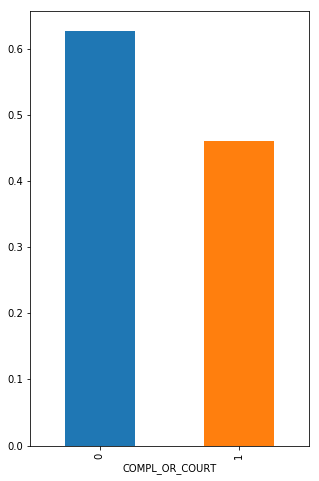

In [209]:
tab1 = pd.crosstab(train['POLICY_IS_RENEWED'], train['COMPL_OR_COURT'], margins = True)
tab1.loc[1, :].divide(tab1.loc['All', :]).head(2).plot(kind = 'bar', figsize = (5, 8))

INSURER_GENDER,F,M
POLICY_HAS_COMPLAINTS,,
0,0.991715,0.993275
1,0.008285,0.006725


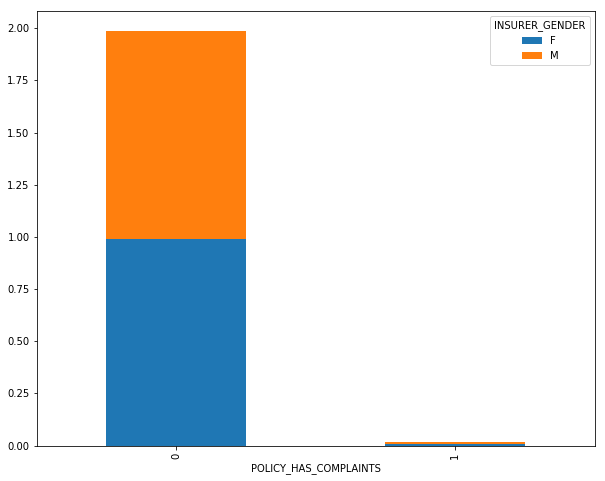

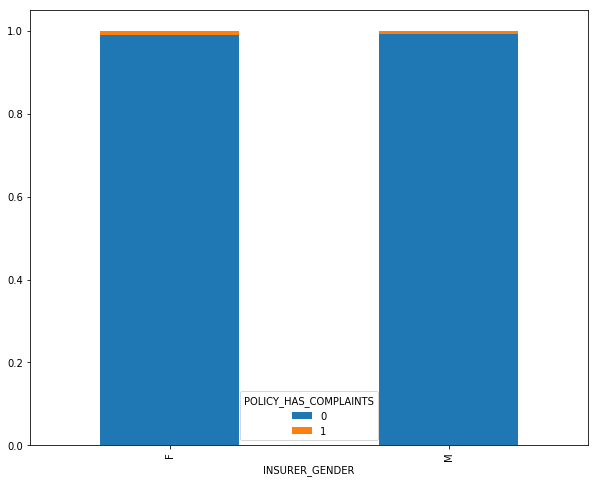

In [217]:
tab1 = pd.crosstab(train['INSURER_GENDER'].map({0: 'M', 1: 'F'}), train['POLICY_HAS_COMPLAINTS'], margins = True)
for column in tab1.columns[:-1]:
    tab1.at[:, column] = tab1.loc[:, column].divide(tab1.loc[:, 'All'])
tab1 = tab1.drop('All', axis = 1).drop('All').transpose()
tab1.plot.bar(stacked = 'Yes', figsize = (10, 8))
tab1.transpose().plot.bar(stacked = 'Yes', figsize = (10, 8))
tab1

INSURER_GENDER,F,M
POLICY_COURT_SIGN,,
0,0.999157,0.998937
1,0.000843,0.001063


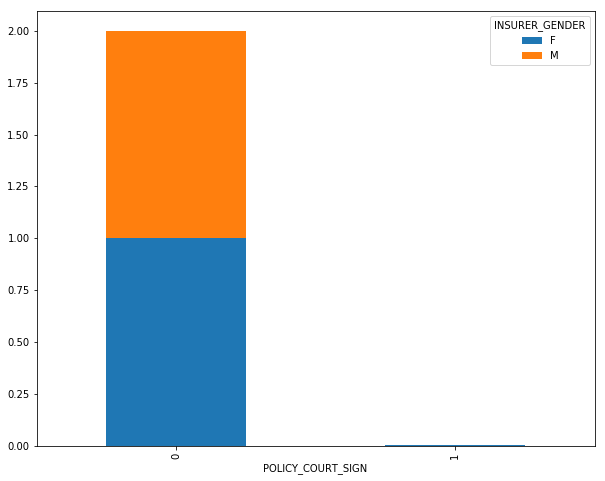

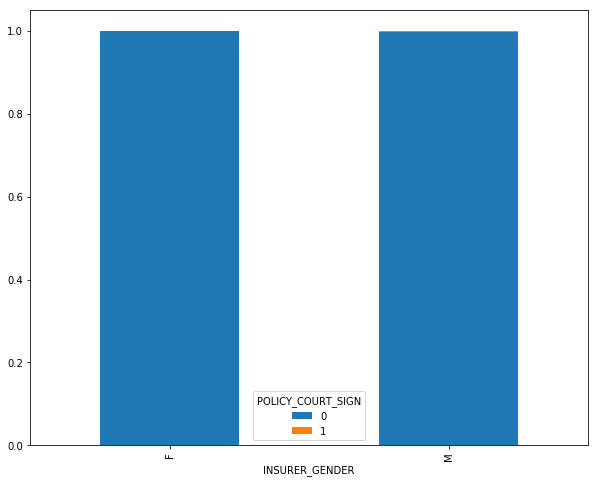

In [218]:
tab1 = pd.crosstab(train['INSURER_GENDER'].map({0: 'M', 1: 'F'}), train['POLICY_COURT_SIGN'], margins = True)
for column in tab1.columns[:-1]:
    tab1.at[:, column] = tab1.loc[:, column].divide(tab1.loc[:, 'All'])
tab1 = tab1.drop('All', axis = 1).drop('All').transpose()
tab1.plot.bar(stacked = 'Yes', figsize = (10, 8))
tab1.transpose().plot.bar(stacked = 'Yes', figsize = (10, 8))
tab1

In [ ]:
tmp = train.copy()
tmp['INSURER_GENDER'] = tmp['INSURER_GENDER'].map({0: 'M', 1: 'F'})

In [240]:
print(tmp.groupby(['POLICY_IS_RENEWED', 'INSURER_GENDER'])['POLICY_COURT_SIGN'].sum())
print(tmp['INSURER_GENDER'].value_counts())

POLICY_IS_RENEWED  INSURER_GENDER
0                  F                 21
                   M                 48
1                  F                  3
                   M                  4
Name: POLICY_COURT_SIGN, dtype: int64
M    48923
F    28484
Name: INSURER_GENDER, dtype: int64


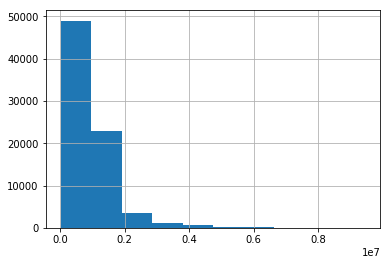

In [178]:
data[data['VEHICLE_SUM_INSURED'] > 0]['VEHICLE_SUM_INSURED'].hist()

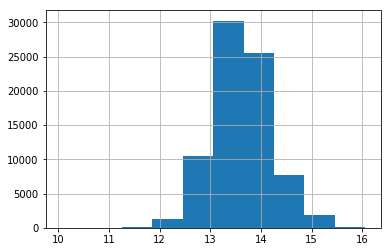

In [179]:
data[data['VEHICLE_SUM_INSURED'] > 0]['VEHICLE_SUM_INSURED'].map(np.log1p).hist()

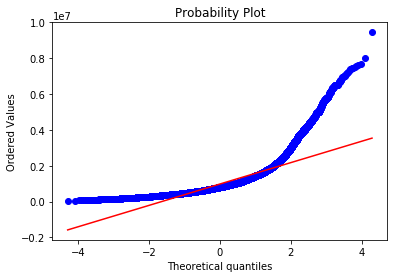

In [180]:
stats.probplot(data[data['VEHICLE_SUM_INSURED'] > 0]['VEHICLE_SUM_INSURED'], dist = 'norm', plot = pylab)
pylab.show()

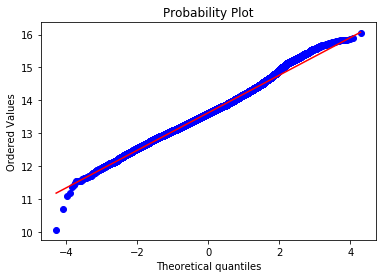

In [181]:
stats.probplot(data[data['VEHICLE_SUM_INSURED'] > 0]['VEHICLE_SUM_INSURED'].map(np.log1p), dist = 'norm', plot = pylab)
pylab.show()